In [ ]:
import os
from pathlib import Path
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras, lite
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sys import getsizeof
import re
import cv2
from sklearn.model_selection import train_test_split

print(tf.__version__)


2.8.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_folder = 'drive/MyDrive/testStuff'
sub_folder_list = os.listdir(input_folder)
# input_folder = pathlib.Path("drive/MyDrive/newData")
# bow_playing_dir = input_folder / "bowPlaying"

data_images_with_labels = []
data_images = []
data_labels = []
for i in range(len(sub_folder_list)):
    if sub_folder_list[i]=='bow_playing':
        int_label = 0
    if sub_folder_list[i]=='not_playing':
        int_label = 1
    # if sub_folder_list[i]=='pizz':
    #     int_label = 2
    # if sub_folder_list[i]=='unsure':
    #     int_label = 3
    #print(os.path.join(input_folder,sub_folder_list[i]))
    images_list = os.listdir(os.path.join(input_folder,sub_folder_list[i]))
    #print(images_list)
    images_list.sort(key=lambda f: int(re.sub('\D', '', f)))
    #print(images_list)

    for j in range(len(images_list)):
        img = cv2.imread(os.path.join(input_folder,sub_folder_list[i],images_list[j]))
        # img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
        # ABOVE LINE CONVERTS TO GREYSCALE
        #data_images_with_labels.append([img,sub_folder_list[i]])
        data_images.append(img)
        
        data_labels.append(int_label)


X_train, X_test, y_train, y_test = train_test_split(data_images, data_labels, test_size=0.33, random_state=42)
train_images = np.asarray(X_train, dtype=None, order=None)
test_images = np.asarray(X_test, dtype=None, order=None)
train_labels = np.asarray(y_train, dtype=None, order=None)
test_labels = np.asarray(y_test, dtype=None, order=None)

In [ ]:
"""# Helper Functions"""

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [ ]:
print(train_images.shape)
print(train_labels[1])

class_names = ['bow_playing', 'not_playing']

"""## Explore the data"""

train_images.shape

len(train_labels)

np.unique(train_labels)


(459, 200, 200, 3)
0


array([0, 1])

You should have a separate file that maps your class labels to your class names. 

Since tf.keras.utils.image_dataset_from_directory will generate labels, just write down somewhere which number is associated to which, rather than it being based on position.
```
class_names = ['bowPlaying', 'notPlaying', 'pizz']
```

In [ ]:
"""# Test Dataset"""

test_images.shape

len(test_labels)


227

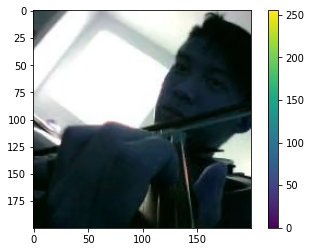

In [ ]:
"""## Preprocessing"""

train_img = train_images[1]
plt.figure()
# plt.imshow(train_images[1], cmap="gray")
plt.imshow(train_images[1])
plt.colorbar()
plt.grid(False)
plt.show()
#
train_images = train_images / 255.0
test_images = test_images / 255.0


In [ ]:
"""## Build & Compile the model

"""

model = keras.Sequential([
    Flatten(input_shape=(200, 200, 3)), 
    Dense(64, activation='relu'), #input layer
    BatchNormalization(),
    Dense(2, activation = 'softmax') #output layer
])

model.summary()


# model.compile(optimizer='adam',
#               loss= SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.5),
#     loss=SparseCategoricalCrossentropy(from_logits=True),
#     metrics=[
#         tf.keras.metrics.BinaryAccuracy(name='accuracy')
#     ]
# )
STEPS_PER_EPOCH = 290

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.0000006,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

model.compile(tf.keras.optimizers.Adam(lr_schedule),
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# def get_optimizer():
#   return tf.keras.optimizers.Adam(lr_schedule)

# model.compile(tf.keras.optimizers.schedules.InverseTimeDecay,
#               loss= SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=40) #damn only 1 lol

KERAS_MODEL_NAME = "tf_model.h5"

model.save(KERAS_MODEL_NAME)

convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

keras_model_size = get_file_size(KERAS_MODEL_NAME)

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy is {}%'.format(round(100*test_acc, 2)))


# def plot_metric(history, metric):
#     train_metrics = history.history[metric]
#     val_metrics = history.history['val_'+metric]
#     epochs = range(1, len(train_metrics) + 1)
#     plt.plot(epochs, train_metrics)
#     plt.plot(epochs, val_metrics)
#     plt.title('Training and validation '+ metric)
#     plt.xlabel("Epochs")
#     plt.ylabel(metric)
#     plt.legend(["train_"+metric, 'val_'+metric])
#     plt.show()

# plot_metric(history, 'accuracy')
# plot_metric(history, 'loss')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 120000)            0         
                                                                 
 dense (Dense)               (None, 64)                7680064   
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 7,680,450
Trainable params: 7,680,322
Non-trainable params: 128
_________________________________________________________________
Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


15/15 [==============================] - 2s 87ms/step - loss: 1.0053 - accuracy: 0.5534
Epoch 2/40
15/15 [==============================] - 1s 84ms/step - loss: 0.8378 - accuracy: 0.5969
Epoch 3/40
15/15 [==============================] - 1s 84ms/step - loss: 0.7689 - accuracy: 0.6623
Epoch 4/40
15/15 [==============================] - 1s 86ms/step - loss: 0.7255 - accuracy: 0.6776
Epoch 5/40
15/15 [==============================] - 1s 85ms/step - loss: 0.6699 - accuracy: 0.7255
Epoch 6/40
15/15 [==============================] - 1s 84ms/step - loss: 0.6386 - accuracy: 0.7560
Epoch 7/40
15/15 [==============================] - 1s 85ms/step - loss: 0.6179 - accuracy: 0.7669
Epoch 8/40
15/15 [==============================] - 1s 84ms/step - loss: 0.5823 - accuracy: 0.7930
Epoch 9/40
15/15 [==============================] - 1s 83ms/step - loss: 0.5607 - accuracy: 0.8105
Epoch 10/40
15/15 [==============================] - 1s 84ms/step - loss: 0.5406 - accuracy: 0.8301
Epoch 11/40
15/15 [=

In [ ]:
"""# TF Lite Model"""

TF_LITE_MODEL_FILE_NAME = "tf_lite_model_aug1.tflite"

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

tflite_model_name = TF_LITE_MODEL_FILE_NAME #A CHANGE HERE
with open(tflite_model_name, "wb") as file:
  file.write(tflite_model)

convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

tflite_file_size = get_file_size(TF_LITE_MODEL_FILE_NAME)



INFO:tensorflow:Assets written to: /tmp/tmpvkvxy9xu/assets


File size: 30002.715 Kilobytes


In [ ]:
def representative_dataset():
    for _ in range(100):
        data = np.random.rand(1, 200, 200, 3) #1 instead of 3
        yield [data.astype(np.float32)]

# Convert the tflite.
converter = lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

# Save the model.
with open('tf_lite_model_quantized.tflite', 'wb') as f:
  f.write(tflite_quant_model)

convert_bytes(get_file_size('tf_lite_model_quantized.tflite'), "KB")

tflite_file_size = get_file_size('tf_lite_model_quantized.tflite')


INFO:tensorflow:Assets written to: /tmp/tmpv8o91lep/assets


INFO:tensorflow:Assets written to: /tmp/tmpv8o91lep/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


File size: 7502.625 Kilobytes


400
prediction is: 1
1
prediction is: 0
1
prediction is: 1
1
prediction is: 0
1
prediction is: 1
1
prediction is: 1
1
prediction is: 1
1
prediction is: 1
1
prediction is: 1
1
prediction is: 1
1
prediction is: 0
1
prediction is: 1
1
prediction is: 1
1
prediction is: 1
1
prediction is: 1
1
prediction is: 1
1
prediction is: 1
1
prediction is: 0
1
prediction is: 0
1
prediction is: 1
1
prediction is: 1
1
prediction is: 1
1
prediction is: 1
1
prediction is: 0
1
prediction is: 1
1
prediction is: 1
1
prediction is: 0
1
prediction is: 1
1
prediction is: 0
1
prediction is: 1
1
prediction is: 0
1
prediction is: 1
1
prediction is: 0
1
prediction is: 0
1
prediction is: 0
1
prediction is: 1
1
prediction is: 0
1
prediction is: 1
1
prediction is: 1
1
prediction is: 1
1
prediction is: 1
1
prediction is: 0
1
prediction is: 0
1
prediction is: 1
1
prediction is: 1
1
prediction is: 0
1
prediction is: 0
1
prediction is: 1
1
prediction is: 1
1
prediction is: 1
1
prediction is: 0
1
prediction is: 1
1
predicti

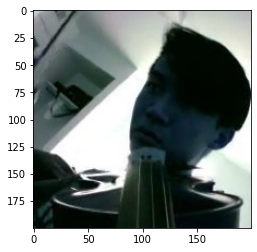

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])


  test_folder = 'drive/MyDrive/test'
  # test_folder = 'drive/MyDrive/newData/notPlaying'
  test_images = os.listdir(test_folder)

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i in range(len(test_images)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = cv2.imread(os.path.join(test_folder,test_images[i]))
    # test_image = cv2.cvtColor(test_image_rgb, cv2.COLOR_BGR2GRAY)
    # print(test_image)
    # print(interpreter.get_input_details())
    plt.imshow(test_image, cmap="gray")
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    # test_image = np.expand_dims(test_image, axis=3).astype(np.float32) #4 dimensions i think is fucking it up


    # print(test_image.shape)
    # print(interpreter.get_input_details())
    # print(input_tensor_index)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels (txt) to calculate accuracy.
  def readFile(fileName):
      fileObj = open(fileName, "r") #opens the file in read mode
      words = fileObj.read().splitlines() #puts the file into an array
      fileObj.close()
      return words

  test_labels = readFile('drive/MyDrive/test_labels.txt')

  accurate_count = 0
  print(len(prediction_digits))
  for index in range(len(prediction_digits)):
    print('prediction is: ' + str(prediction_digits[index]))
    print(test_labels[index])
    if str(prediction_digits[index]) == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

def evaluate_tflite_quant_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])


  test_folder = 'drive/MyDrive/test'
  # test_folder = 'drive/MyDrive/newData/notPlaying'
  test_images = os.listdir(test_folder)

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i in range(len(test_images)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = cv2.imread(os.path.join(test_folder,test_images[i]))
    # test_image = cv2.cvtColor(test_image_rgb, cv2.COLOR_BGR2GRAY)
    # print(test_image)
    # print(interpreter.get_input_details())
    plt.imshow(test_image, cmap="gray")
    test_image = np.expand_dims(test_image, axis=0).astype(np.int8)
    # test_image = np.expand_dims(test_image, axis=3).astype(np.int8) #4 dimensions i think is fucking it up


    # print(test_image.shape)
    # print(interpreter.get_input_details())
    # print(input_tensor_index)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels (txt) to calculate accuracy.
  def readFile(fileName):
      fileObj = open(fileName, "r") #opens the file in read mode
      words = fileObj.read().splitlines() #puts the file into an array
      fileObj.close()
      return words

  test_labels = readFile('drive/MyDrive/test_labels.txt')

  accurate_count = 0
  print(len(prediction_digits))
  for index in range(len(prediction_digits)):
    print('prediction is: ' + str(prediction_digits[index]))
    print(test_labels[index])
    if str(prediction_digits[index]) == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy



# Evaluate the TF Lite float model. You'll find that its accurary is identical
# to the original TF (Keras) model because they are essentially the same model
# stored in different format.
newaccuracy = evaluate_tflite_model(tflite_model)
print('Float model accuracy = %.4f' % newaccuracy)

# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)

quantized_accuracy = evaluate_tflite_quant_model(tflite_quant_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
print('Accuracy drop = %.4f' % (newaccuracy - quantized_accuracy))

